In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [5]:
data = pd.read_csv("train.csv")

# Dropping unnecessery columns
data = data.drop('Unnamed: 0', axis=1)

In [7]:
# Detecting missing values
data.isnull().sum()

Unnamed: 0                        0
n_visits                          0
n_actions                         0
unique_actions                    0
products_tried                    0
products_added                    0
unique_products_category_tried    0
unique_products_category_added    0
saved_to_cart                     0
comments_writen                   0
counts_of_buys                    0
came_back                         0
dtype: int64

In [4]:
# Visually analysing the outlier issue using descriptive statistics
data.describe()

,Unnamed: 0,n_visits,n_actions,unique_actions,products_tried,products_added,unique_products_category_tried,unique_products_category_added,saved_to_cart,comments_writen,counts_of_buys,came_back
count,658052.000000,658052.000000,658052.000000,658052.000000,658052.000000,658052.000000,658052.000000,658052.000000,658052.000000,658052.000000,658052.000000,658052.000000
mean,469962.923185,8.477398,537.548177,65.913323,5.937011,1.210488,10.309620,4.595120,0.529280,3.532087,5.349092,0.320338
std,271396.332262,30.431194,964.670595,34.721370,16.296478,2.660344,21.909215,5.656423,0.499142,9.826804,13.434137,0.466607
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,235061.750000,1.000000,90.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,469900.500000,3.000000,236.000000,62.000000,1.000000,0.000000,2.000000,3.000000,1.000000,1.000000,1.000000,0.000000
75%,705102.250000,8.000000,594.000000,87.000000,4.000000,1.000000,10.000000,7.000000,1.000000,3.000000,6.000000,1.000000
max,940074.000000,5996.000000,75408.000000,347.000000,596.000000,73.000000,597.000000,118.000000,1.000000,1212.000000,1591.000000,1.000000


In [5]:
# Detecting duplicates in data
data.duplicated().sum()

0

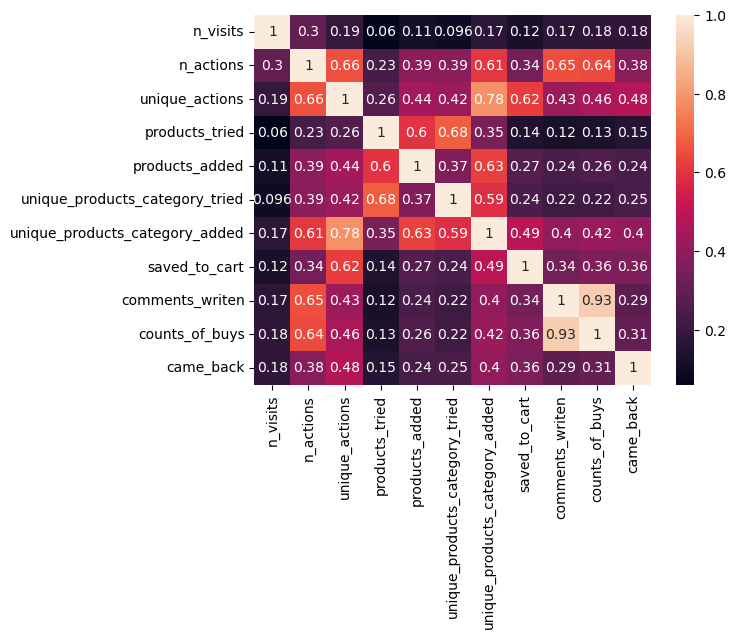

In [132]:
# Detecting multicollinearity issue in our dataset
sns.heatmap(data.corr(), annot=True)
plt.show()

In [142]:
# As we can see there is a significant correlation between comments written and counts of buys equal to 0.93.

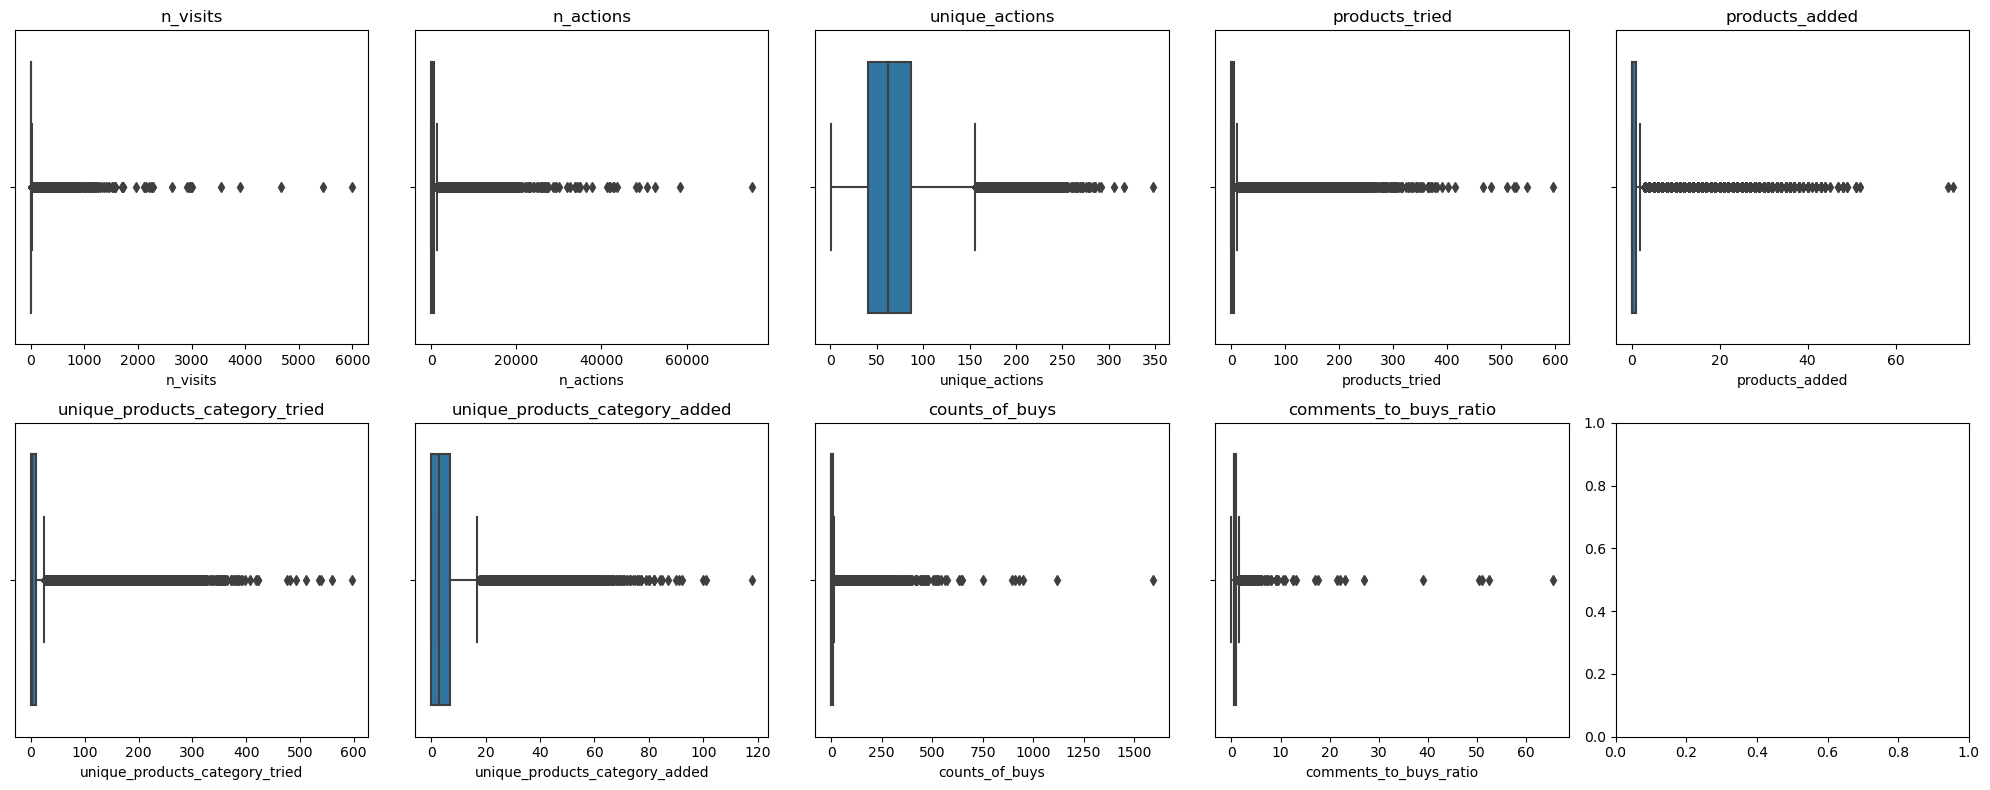

In [175]:
# Detecting the outlier issue
# As 'saved_to_cart' is from 0 to 1, we won't visualize its outliers.

num_columns = data.select_dtypes(include=[np.number]).drop(['came_back', 'saved_to_cart'], axis=1).columns

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, column in enumerate(num_columns):
    row = i // 5
    col = i % 5
    sns.boxplot(x=data[column], ax=axes[row, col])
    axes[row, col].set_title(column)
plt.tight_layout()
plt.show()

In [177]:
data.shape

(658052, 11)

In [ ]:
# Cleaning the data

In [ ]:
# To deal with the correlation issue without losing information we create a new feature calculating the ratio of comments to buys,
# which might indicate how actively engaged users are in discussing the products they purchased.
# After that we remove one of the correlated features, in this case 'comments_writen'.

In [ ]:
# As I have tried different modifications on my original dataset, and the best results I had with okdata,
# I won't change its name, and In the rest of my research I will use the okdata as the main cleaned dataset.

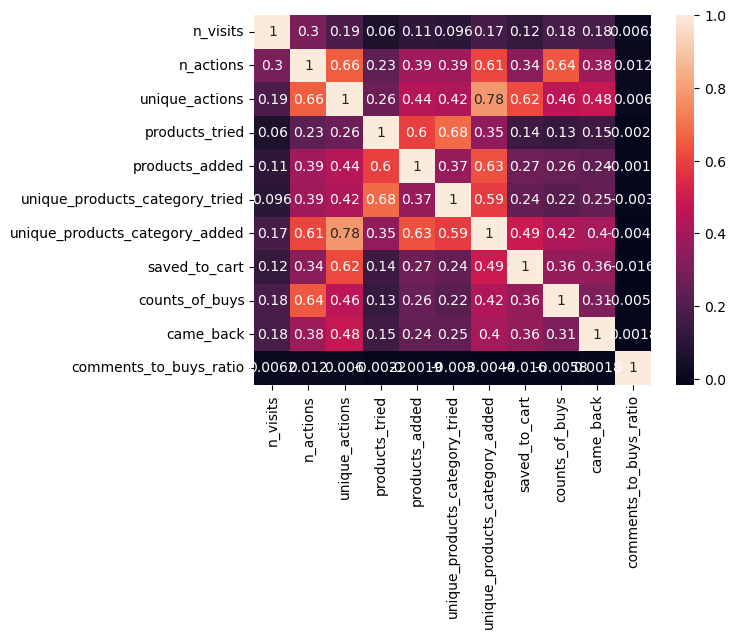

In [6]:
okdata = data

epsilon = 1e-8
okdata['comments_to_buys_ratio'] = okdata['comments_writen'] / (okdata['counts_of_buys'] + epsilon)

okdata = okdata.drop(['comments_writen'], axis=1)
sns.heatmap(okdata.corr(), annot=True)
plt.show()

In [7]:
# Then we remove the outliers based on IQR:

num_columns = okdata.select_dtypes(include=[np.number]).drop(['came_back', 'saved_to_cart', 'comments_to_buys_ratio'], axis=1).columns

for column in num_columns:
    Q1 = okdata[column].quantile(0.25)
    Q3 = okdata[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    okdata = okdata[(okdata[column] >= lower_bound) & (okdata[column] <= upper_bound)]

print(f"Cleaned data shape: {okdata.shape}")

Cleaned data shape: (345044, 11)


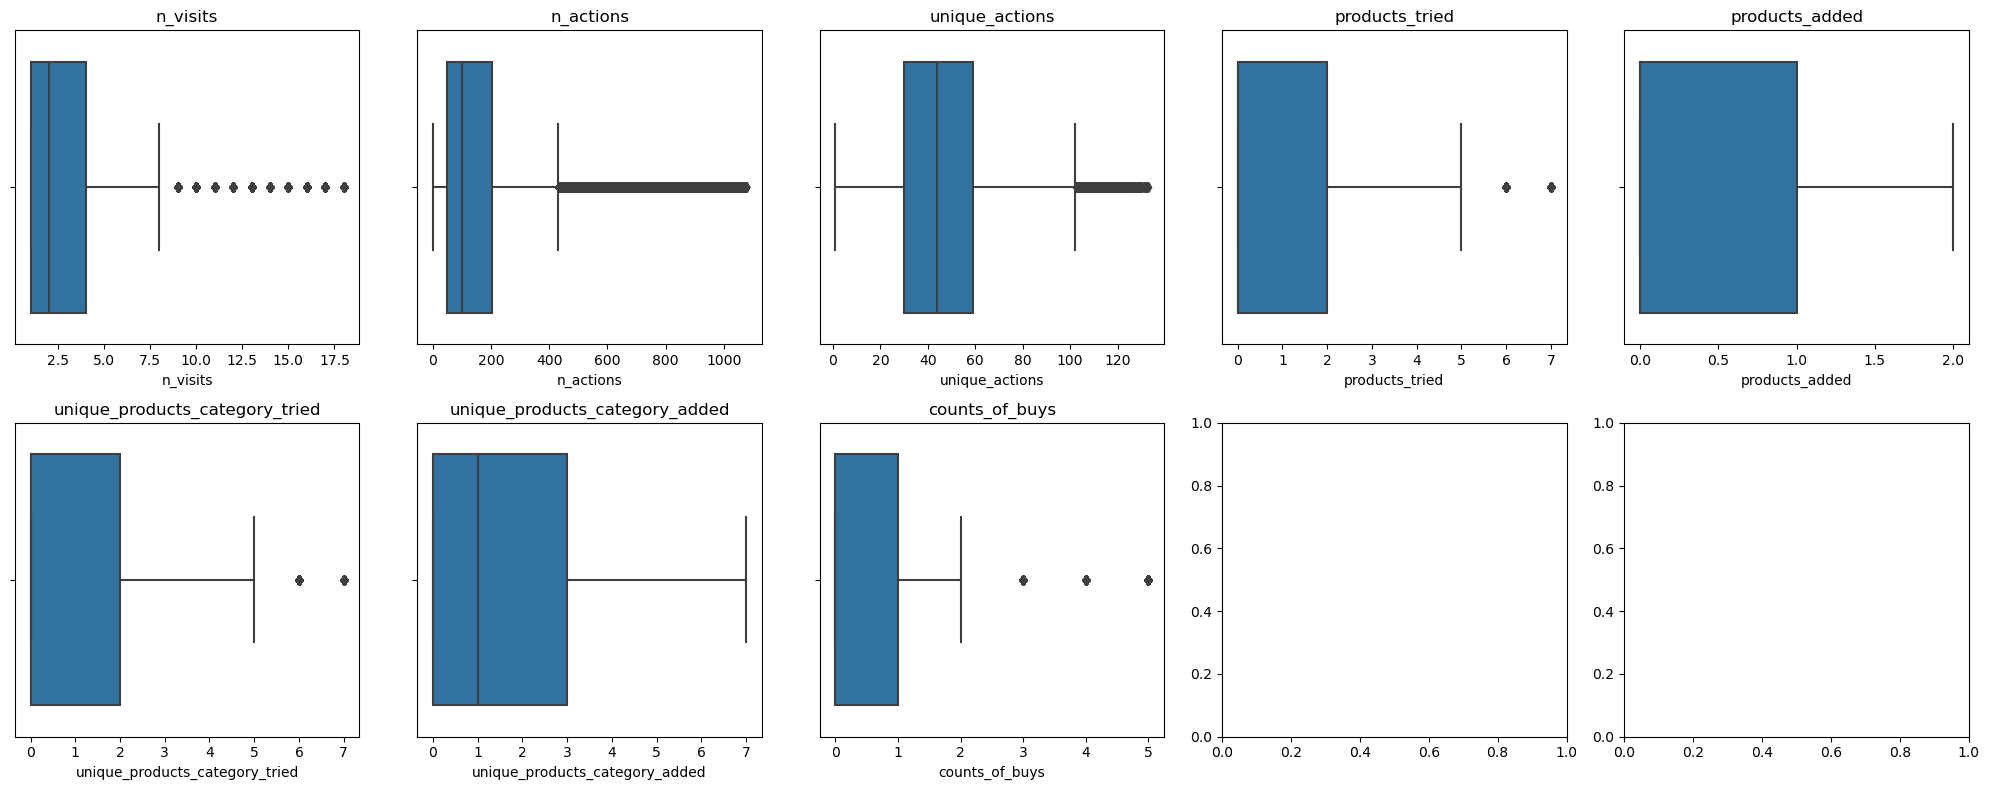

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, column in enumerate(num_columns):
    row = i // 5
    col = i % 5
    sns.boxplot(x=okdata[column], ax=axes[row, col])
    axes[row, col].set_title(column)
plt.tight_layout()
plt.show()

In [ ]:
# KNN

In [268]:
# Now having the data of the best obtained model, let's do grid search to adjust the best params.

In [269]:
okdata.shape

(345044, 11)

In [ ]:
# Train-test split
X = okdata.drop("came_back", axis=1)
y = okdata['came_back']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [270]:
# KNN best hyperparameeters grid search

pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('knn', KNeighborsClassifier())])

param_grid={'knn__n_neighbors': [11, 21, 25, 29, 31, 41, 99]}
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [11, 21, 25, 29, 31, 41, 99]},
             scoring='accuracy')

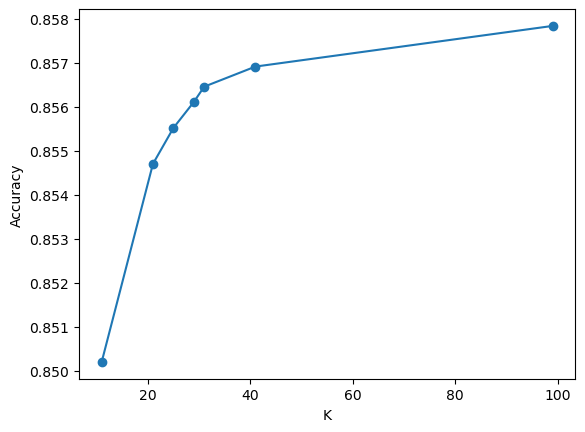

In [273]:
mean_test_scores = grid_search.cv_results_['mean_test_score']
plt.plot([11, 21, 25, 29, 31, 41, 99], mean_test_scores, marker = 'o')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

In [271]:
# After knowing "31" is the best k for the best data, we can test the best model here.

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [277]:
# Creating the KNN model with the optimal k value
best_knn_model = KNeighborsClassifier(n_neighbors=31)

# Fitting the optimal KNN model to the standardized training data
best_knn_model.fit(X_train_scaled, y_train)

# Calculating the training accuracy
train_accuracy = best_knn_model.score(X_train_scaled, y_train)
print(f"Training accuracy: {train_accuracy}")

# Calculating the test accuracy
test_accuracy = best_knn_model.score(X_test_scaled, y_test)
print(f"Test accuracy: {test_accuracy}")


C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Training accuracy: 0.8628256032253597


C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Test accuracy: 0.8528908853789305


In [ ]:
# So now we have 31 as the most optimall number for knn__n_neighbors
# And the most accurate model we got using our okdata: "best_knn_model"

In [278]:
okdata.shape

(345044, 11)

In [282]:
# Decision tree

In [290]:
dt_model = DecisionTreeClassifier()
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 4, 8, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'splitter': ['best', 'random']
}
grid_search = GridSearchCV(dt_model, params, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best hyperparameters found by grid search: \n{grid_search.best_params_}")

Best hyperparameters found by grid search: 
{'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 8, 'splitter': 'best'}


In [291]:
dt_model = DecisionTreeClassifier(**grid_search.best_params_)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, max_features='auto', min_samples_split=8)

In [9]:
y_pred = dt_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='plasma')
plt.xlabel("Prediction label")
plt.ylabel("True label")
plt.show()

NameError: name 'dt_model' is not defined

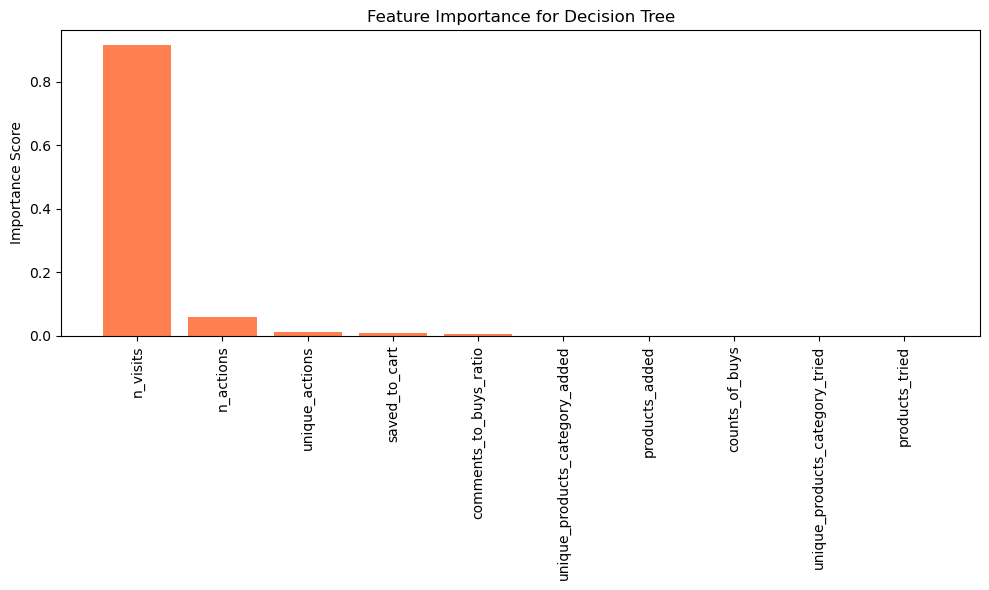

In [295]:
# Calculating the training and testing accuracies
train_accuracy = dt_model.score(X_train, y_train)
print(f"Training accuracy: {train_accuracy}")

test_accuracy = dt_model.score(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

Training accuracy: 0.8568843204879258
Test accuracy: 0.8524561657730764


In [302]:
# Logistic Regression

In [320]:
log_reg = LogisticRegression()

param_grid = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print(f"Best hyperparameters found by grid search: \n{grid_search.best_params_}")

best_log_reg = grid_search.best_estimator_

y_train_pred = best_log_reg.predict(X_train_scaled)
y_test_pred = best_log_reg.predict(X_test_scaled)

train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training accuracy: {train_accuracy}")

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy}")

Best hyperparameters found by grid search: 
{'C': 0.0001}
Training accuracy: 0.8563529862593748
Test accuracy: 0.8534415302130126


In [ ]:
# So now we have "best_log_reg" as our regression model with the accuracy 0.86

In [321]:
# Bayesyan inference

In [328]:
# Creating a Gaussian Naive Bayes model
gnb_model = GaussianNB()

gnb_model.fit(X_train_scaled, y_train)

y_train_pred = gnb_model.predict(X_train_scaled)
y_test_pred = gnb_model.predict(X_test_scaled)

train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training accuracy: {train_accuracy}")

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy}")

Training accuracy: 0.7870959847233359
Test accuracy: 0.7842051876539632


In [ ]:
# The model with the least accuracy is "gnb_model" Gaussian Native Bayes model.